In [1]:
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

In [2]:
from functions import *

In [23]:
#GRAPH STRUCTURE OPTIMIZATION TEST
x = np.linspace(0,math.pi,100)
y = np.sin(x)#2*x + 1
data = {"x":x,"y":y}

In [20]:
%lprun -f evolution evolution(data, 5)

evolving generation 0 of 5


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  gr

min error at generation n.0: 20.0435001263
evolving generation 1 of 5


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_her

min error at generation n.1: 14.9990234817
evolving generation 2 of 5


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","functi

min error at generation n.2: 9.80789511709
evolving generation 3 of 5


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function

min error at generation n.3: 9.80879425419
evolving generation 4 of 5


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","functio

min error at generation n.4: 8.29506059437


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"

In [27]:
result = {'specimen': [{'lib_id': 2, 'input': [6, 1]}, {'lib_id': 3, 'input': [3, 6]}, {'arg_index': 0, 'lib_id': 0, 'input': []}, {'lib_id': 3, 'input': [2, 4]}, {'lib_id': 3, 'input': [6, 6]}, {'arg_index': 1, 'lib_id': 0, 'input': []}, {'lib_id': 3, 'input': [5, 7]}, {'lib_id': 3, 'input': [9, 9]}, {'arg_index': 2, 'lib_id': 0, 'input': []}, {'lib_id': 2, 'input': [8, 11]}, {'arg_index': 3, 'lib_id': 0, 'input': []}, {'lib_id': 3, 'input': [10, 8]}], 'error': 6.8198719261941951}

In [112]:
def export_json_graph(graph):
    import json
    import networkx as nx
    from io import StringIO
    from networkx.readwrite import json_graph

    G =nx.MultiDiGraph()

    for n, node in enumerate(graph):
        G.add_node(n, attr_dict=node)

    for n1, node in enumerate(graph):
        for i, n2 in enumerate(node["input"]):
            G.add_edge(n2, n1, attr_dict={"arg":i})

    json_data = json_graph.node_link_data(G)

    for n, node in enumerate(json_data["nodes"]):
        symbol = lib[node["lib_id"]]["symbol"]

        if symbol == "v":
            symbol = node["arg_index"]

        json_data["nodes"][n] = {"id":node["id"], "symbol":symbol}

    
    buffer = StringIO()
    json.dump(json_data, buffer)
    return buffer.getvalue()

In [113]:
lib[5]["graph"]

[{'arg_index': 0, 'input': [], 'lib_id': 0},
 {'arg_index': 1, 'input': [], 'lib_id': 0},
 {'input': [0, 1], 'lib_id': 1}]

In [115]:
export_json_graph(result["specimen"])

'{"graph": {}, "multigraph": true, "nodes": [{"symbol": "-", "id": 0}, {"symbol": "*", "id": 1}, {"symbol": 0, "id": 2}, {"symbol": "*", "id": 3}, {"symbol": "*", "id": 4}, {"symbol": 1, "id": 5}, {"symbol": "*", "id": 6}, {"symbol": "*", "id": 7}, {"symbol": 2, "id": 8}, {"symbol": "-", "id": 9}, {"symbol": 3, "id": 10}, {"symbol": "*", "id": 11}], "directed": true, "links": [{"arg": 1, "key": 0, "target": 0, "source": 1}, {"arg": 0, "key": 0, "target": 3, "source": 2}, {"arg": 0, "key": 0, "target": 1, "source": 3}, {"arg": 1, "key": 0, "target": 3, "source": 4}, {"arg": 0, "key": 0, "target": 6, "source": 5}, {"arg": 0, "key": 0, "target": 0, "source": 6}, {"arg": 1, "key": 0, "target": 1, "source": 6}, {"arg": 0, "key": 0, "target": 4, "source": 6}, {"arg": 1, "key": 1, "target": 4, "source": 6}, {"arg": 1, "key": 0, "target": 6, "source": 7}, {"arg": 0, "key": 0, "target": 9, "source": 8}, {"arg": 1, "key": 0, "target": 11, "source": 8}, {"arg": 0, "key": 0, "target": 7, "source":

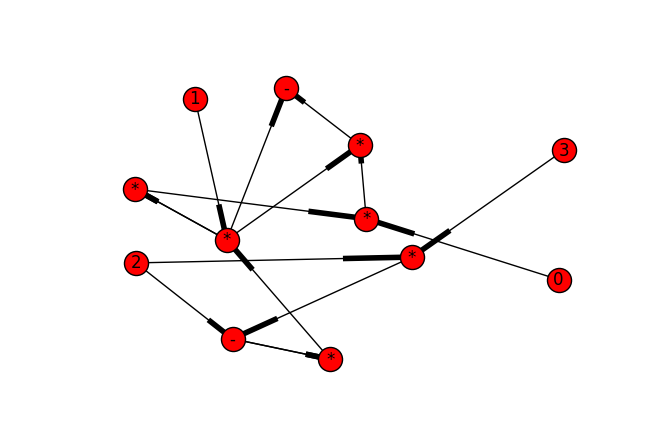

In [116]:
draw(result["specimen"])

evolving generation 0 of 10


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_her

min error at generation n.0: 19.875371192
evolving generation 1 of 10


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"t

min error at generation n.1: 9.79285187474
evolving generation 2 of 10


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","functi

min error at generation n.2: 9.80676266768
evolving generation 3 of 10


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:16: RuntimeWarning: invalid value encountered in subtract
  {"type":"function","function":lambda a:a[0]-a[1],"symbol":"-"},
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encounter

min error at generation n.3: 9.81117469672
evolving generation 4 of 10


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","functio

min error at generation n.4: 9.80275410652
evolving generation 5 of 10


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"t

min error at generation n.5: 9.79749164212
evolving generation 6 of 10


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encoun

min error at generation n.6: 9.80068342165
evolving generation 7 of 10


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"t

min error at generation n.7: 9.79908320456
evolving generation 8 of 10


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]


min error at generation n.8: 9.80364486725
evolving generation 9 of 10


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]


min error at generation n.9: 9.24080425197


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]


{'specimen': [{'lib_id': 2, 'input': [6, 1]}, {'lib_id': 3, 'input': [3, 6]}, {'arg_index': 0, 'lib_id': 0, 'input': []}, {'lib_id': 3, 'input': [2, 4]}, {'lib_id': 3, 'input': [6, 6]}, {'arg_index': 1, 'lib_id': 0, 'input': []}, {'lib_id': 3, 'input': [5, 7]}, {'lib_id': 3, 'input': [9, 9]}, {'arg_index': 2, 'lib_id': 0, 'input': []}, {'lib_id': 2, 'input': [8, 11]}, {'arg_index': 3, 'lib_id': 0, 'input': []}, {'lib_id': 3, 'input': [10, 8]}], 'error': 6.8198719261941951}
fittest specimen:


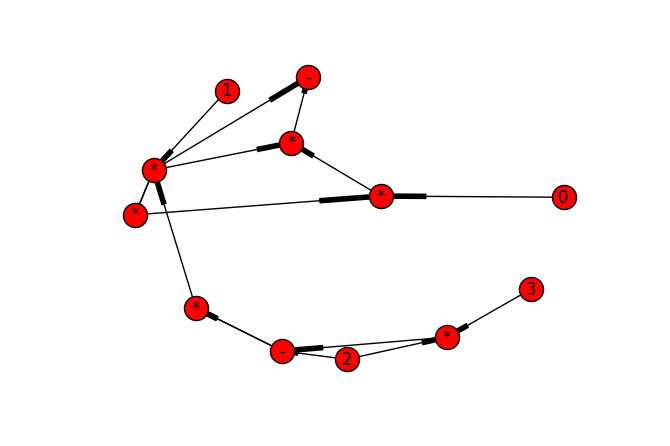

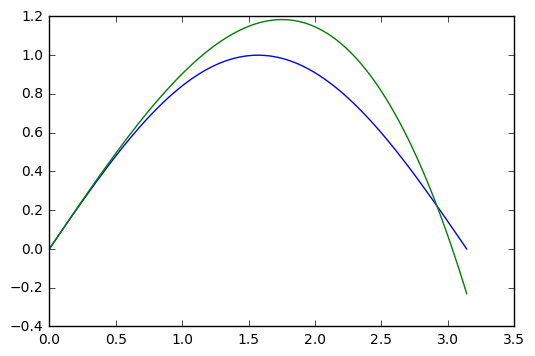

CPU times: user 928 ms, sys: 560 ms, total: 1.49 s
Wall time: 27.6 s


In [24]:
%%time
e = evolution(data, 10)
print(e)
print("fittest specimen:")
draw(e["specimen"])
plot_optimized(e["specimen"],data)

In [22]:
#GRAPH PARAMETER OPTIMIZATION TEST
pylab.close()
x = np.linspace(-10,10,100)
y = 2*x
pylab.plot(x,y)
data = {"x":x,"y":y}
#lib[7] is the A*B graph
%lprun -f optimize optimize(lib[7]["graph"],data,0)

{'iterations': 51, 'parameters': array([ 0.81006931,  2.04725724]), 'error': 7.5945441550180899, 'X': 0}


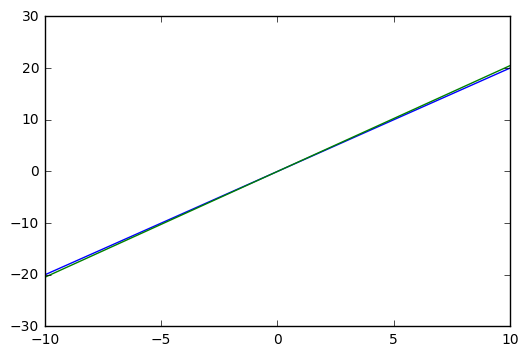

In [416]:
#GRAPH PARAMETER OPTIMIZATION TEST
pylab.close()
x = np.linspace(-10,10,100)
y = 2*x
pylab.plot(x,y)
data = {"x":x,"y":y}
#lib[7] is the A*B graph
result = optimize(lib[7]["graph"],data,0)
print(result)
values = result["parameters"]
x_pos = result["X"]
#input_size*number_of_data_points matrix that contains a list of input vectors like [parameter1, parameter2, x_value, ...]
value_matrix = [[(xe if v == x_pos else value) for v, value in enumerate(values)] for xe in x]
y = np.array([ evaluate(lib[7]["graph"],value_matrix[i]) for i in range(len(value_matrix)) ])
pylab.plot(x,y)
pylab.show()

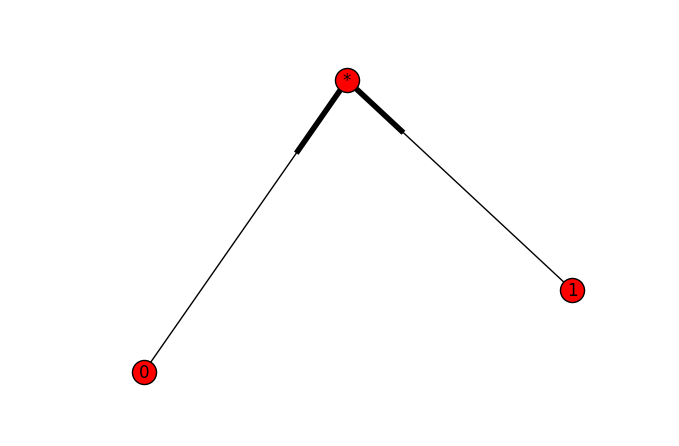

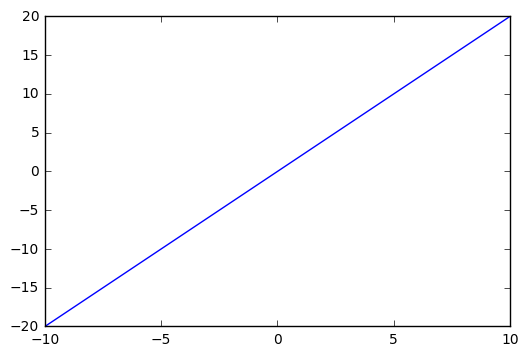

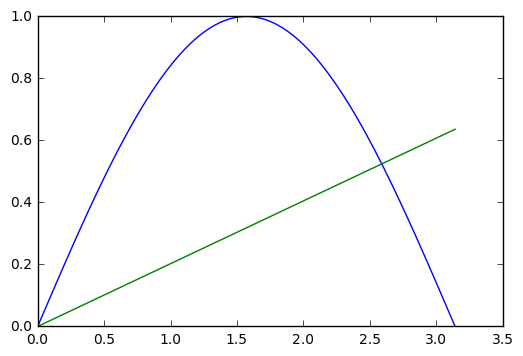

In [352]:
draw(lib[7]["graph"])
plot_specimen(lib[7]["graph"],[2,2])
pylab.close()
x = np.linspace(-10,10,100)
y = 2*x
plot_optimized(lib[7]["graph"],data)

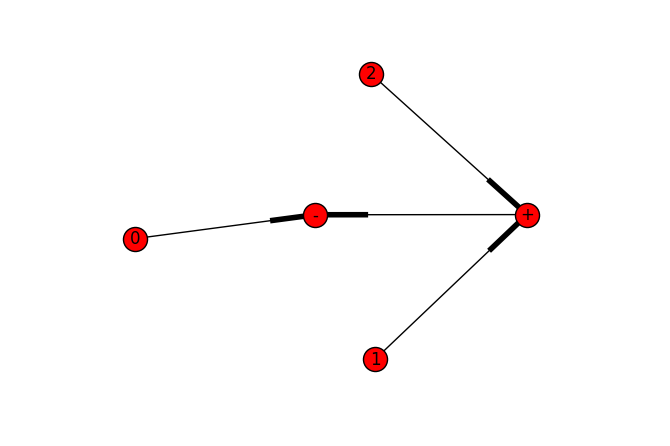

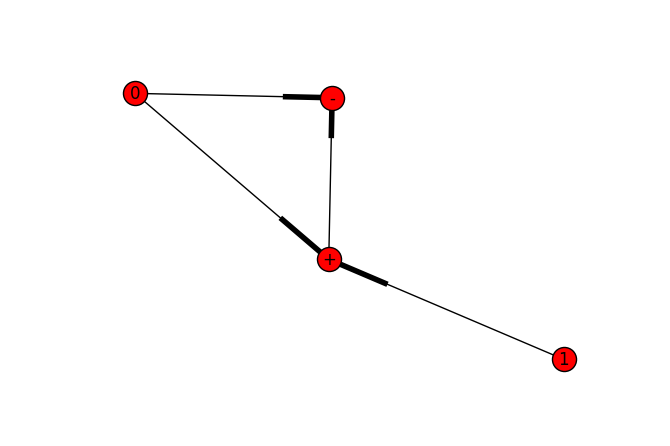

In [353]:
g3 = insert_at(lib[5]["graph"],lib[6]["graph"])
draw(g3)
g4 = merge_input_entries(g3)
draw(g4)

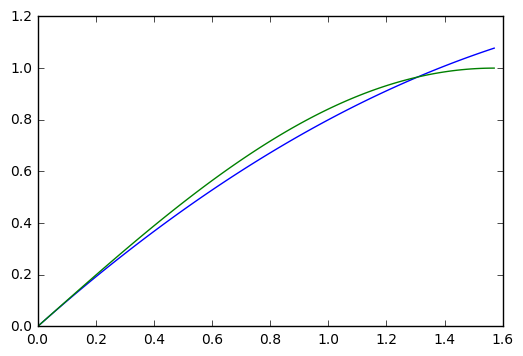

In [357]:
pylab.close()
x = np.linspace(0,math.pi/2,100)
y = x-0.2*x**2
pylab.plot(x,y)
y = np.sin(x)
pylab.plot(x,y)
pylab.show()